### Imports

In [4]:
import torch
import torch_geometric
import torch.nn as nn
import explainer
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import networkx as nx
from typing import Literal
import torch.nn.functional as fn
from torch_geometric.utils import k_hop_subgraph
import utils
from torch_geometric.utils import to_undirected

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(explainer)
importlib.reload(utils)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

### Parameters Explainer

In [5]:
batch_size = 1
sampled_graphs = 20

learning_rate_mlp = 0.003       #Paper: 0.003,
coefficientSizeReg = 0.0001       #Paper: 0.05, code 0, codePyG 0.01
entropyReg = 0.01               #Paper: 1, code 0, codePyG 10.0
epochs_mlp = 10                 #Paper: 30 for all datasets => 20 enough for BA2Motif
coefficientL2Reg = 0.0
# TODO: Budget, connectivity

# Temperature
t_0 =  5.0
t_T = 1.0                       #Paper says 2.0, Code seems to use 1.0 => 1.0 seems to work good

datasetName: Literal['BA-Shapes', 'BA-Community', 'Tree-Cycles', 'Tree-Grid'] = 'Tree-Grid'

## Visualize Data TODO: NodePlot function

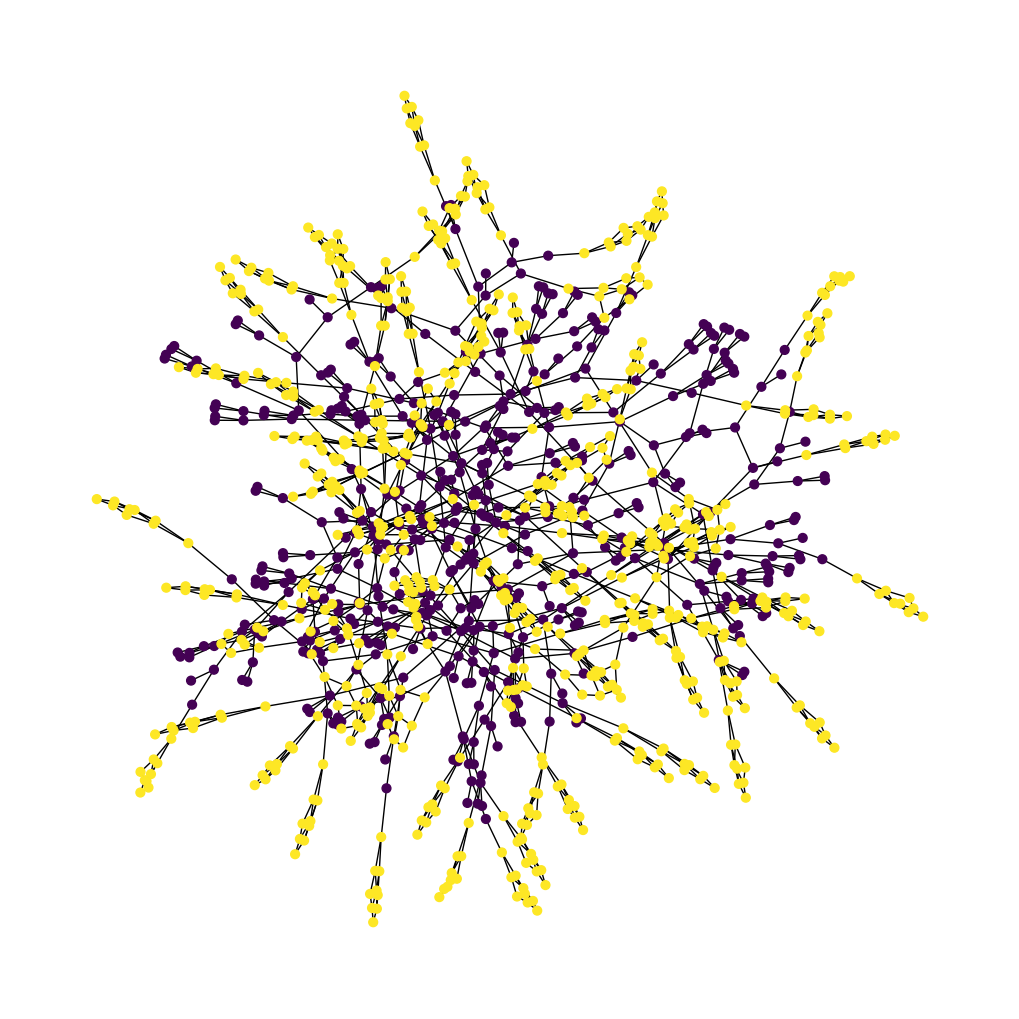

In [6]:
#labels, data = datasetLoader.loadNodeDataset(datasetName)

data, labels = datasetLoader.loadOriginalNodeDataset(datasetName)
motifNodes = [i for i in range(511,800,1)]

pos = utils.plotTreeCycles(data)

### Load GNN model

In [7]:
modelNodeGNN = networks.NodeGNN(features = data.x.shape[1], labels=labels)     # Adjust according to data and task
modelNodeGNN.load_state_dict(torch.load("models/TreeGrid 99 layerNorm latest", weights_only=True))

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.memory_format memory_format = None, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


## RandomAUCNode for evaluation during training. CHANGE

In [5]:
randomAUCNode = torch.randint(511, 880+1, [1]).item()

#[i for i in range(a[0],len(a),6)]
print(randomAUCNode)

584


### Training Loop Graph Classification Explainer

In [6]:
#torch.set_printoptions(threshold=10_000)
mlp = explainer.MLP(GraphTask=False, hidden_dim=64)

mlp_optimizer = torch.optim.Adam(params = mlp.parameters(), lr = learning_rate_mlp, maximize=False)

modelNodeGNN.eval()
for param in modelNodeGNN.parameters():
    param.requires_grad = False

for epoch in range(0, epochs_mlp) :
    mlp.train()
    mlp_optimizer.zero_grad()

    temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))
    #temperature = 5.0

    Loss = torch.FloatTensor([0])

    # Iterate over first motif NODES in data
    #for node_index, nodeFeatures in enumerate(data.x):
    for node_index in motifNodes:
        #Calculate k-hop graph for node
        subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=node_index, num_hops=3, edge_index=data.edge_index, relabel_nodes=False)
        
        # Get index for node to predict in subset, since edge_index is relabeled to match features
        #indexNodeToPred = (subset == node_index).nonzero().item()
        
        # MLP forward                                                           # shape embeddings[batch_index]: ~50 X 60 = Edges X hidden_embs_3Nodes
        w_ij = mlp.forward(modelGraphGNN=modelNodeGNN, x=data.x, edge_index=edge_index_hop, nodeToPred=node_index)               # shape: ~50 X 1 = Edges X MLP_out(edge_weight)

        sampleLoss = torch.FloatTensor([0])
        Loss = torch.FloatTensor([0])
        
        for k in range(0, sampled_graphs):
            # Sample with reparam trick via edge weights
            edge_ij = mlp.sampleGraph(w_ij, temperature)

            # TODO: This softmax is needed for the prediction of the downstream task and should probably be moved into the GNN model!!!
            # until then it is def needed here. Probably correct here, can also be found in og Explainer.call
            # TODO: Hpw do I calc loss? Between k-hop graph and original graph not possible. Only take node_idx from original and sampled?
            pOriginal = fn.softmax(modelNodeGNN.forward(data.x, edge_index_hop), dim=1)
            pSample = fn.softmax(modelNodeGNN.forward(data.x, edge_index_hop, edge_weights=edge_ij), dim=1)

            # TODO: VALIDATE pOriginal and pSample pass both label predictions, not just correct one
            currLoss = mlp.loss(pOriginal[node_index], pSample[node_index], edge_ij, coefficientSizeReg, entropyReg, coefficientL2Reg)        #pOriginal[indexNodeToPred]
            sampleLoss += currLoss
        
        Loss += sampleLoss / sampled_graphs
        
    #Loss = Loss / len(data.x)
    
    Loss.backward()
    
    #Loss = Loss / len(train_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {Loss.item()}")

    torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=2)           # clip value min -2

    mlp_optimizer.step()

    mlp.eval()
    

    evaluation.evaluateNodeExplainerAUC(mlp, modelNodeGNN, data, data.edge_index, randomAUCNode)
    out = mlp.forward(modelNodeGNN, data.x, data.edge_index, randomAUCNode)

    print(f"MLP Output for first val graph in epoch {epoch+1}:")
    print(out)

    """for name, param in mlp.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.grad}")"""

Epoch 1, Loss: 10.105108261108398
AUC of ROC: 0.20000001788139343
BinaryAUROC: 0.2
roc_auc_score: 0.2
MLP Output for first val graph in epoch 1:
tensor([-3.3799, -4.1251, -3.3799,  ..., -2.9171, -0.8845, -2.9171],
       grad_fn=<CopySlices>)
Epoch 2, Loss: 9.884492874145508
AUC of ROC: 0.18333333730697632
BinaryAUROC: 0.18333333333333332
roc_auc_score: 0.18333333333333335
MLP Output for first val graph in epoch 2:
tensor([-5.4541, -6.4508, -5.4541,  ..., -4.4802, -2.1993, -4.4802],
       grad_fn=<CopySlices>)
Epoch 3, Loss: 9.884418487548828
AUC of ROC: 0.18333333730697632
BinaryAUROC: 0.18333333333333332
roc_auc_score: 0.18333333333333335
MLP Output for first val graph in epoch 3:
tensor([-6.9826, -8.4039, -6.9826,  ..., -5.6433, -3.2285, -5.6433],
       grad_fn=<CopySlices>)
Epoch 4, Loss: 9.884418487548828
AUC of ROC: 0.18333333730697632
BinaryAUROC: 0.18333333333333332
roc_auc_score: 0.18333333333333335
MLP Output for first val graph in epoch 4:
tensor([ -8.1981, -10.0208,  -8.1

### TODO: Evaluate AUC for "start node" of each motif: [i for i in range(511,871,6)]

In [12]:
randomAUCNode = torch.randint(511, 800+1, [1]).item()
currentAUC = randomAUCNode

### PROBLEM: Mask predicts 1 for each node, not only motif nodes! Stop weights from growing that huge, grad clipping?

AUC of ROC: 0.0833333358168602
BinaryAUROC: 0.08333333333333333
roc_auc_score: 0.08333333333333333


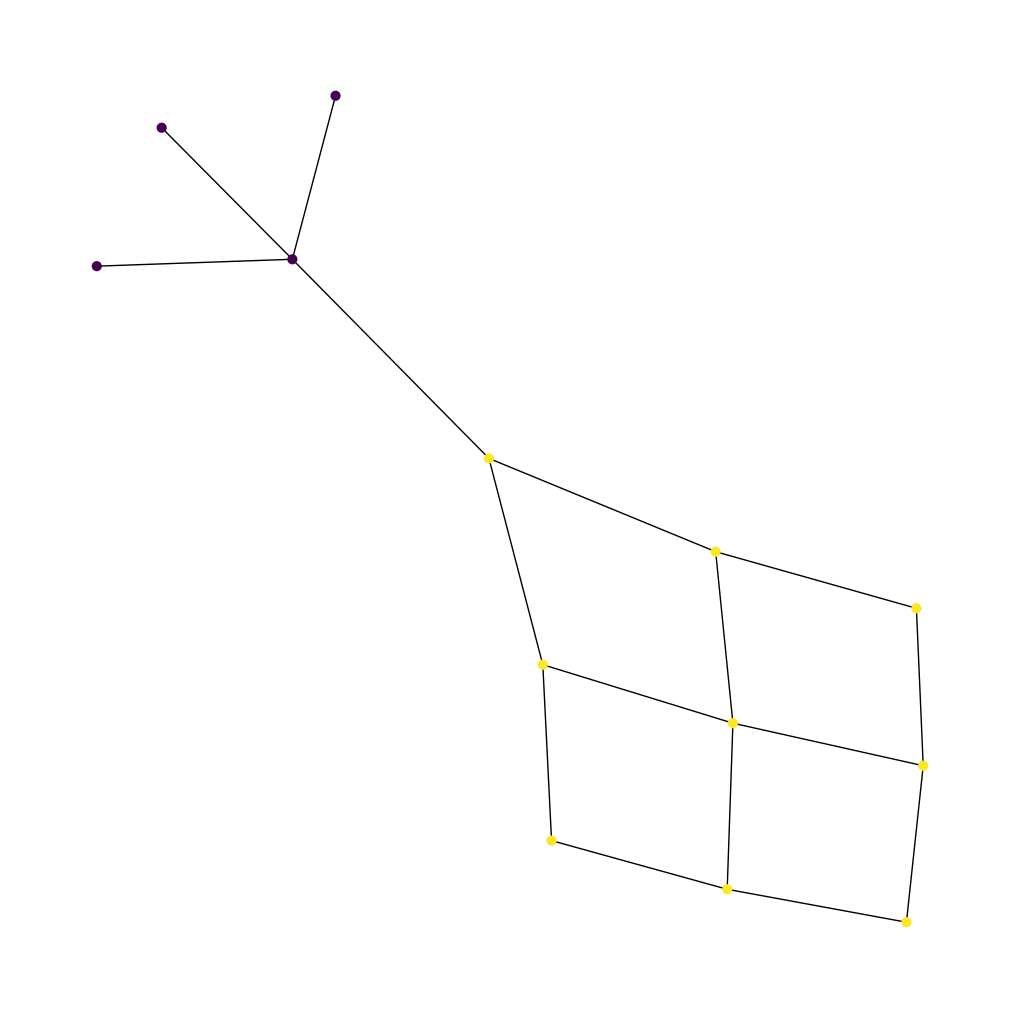

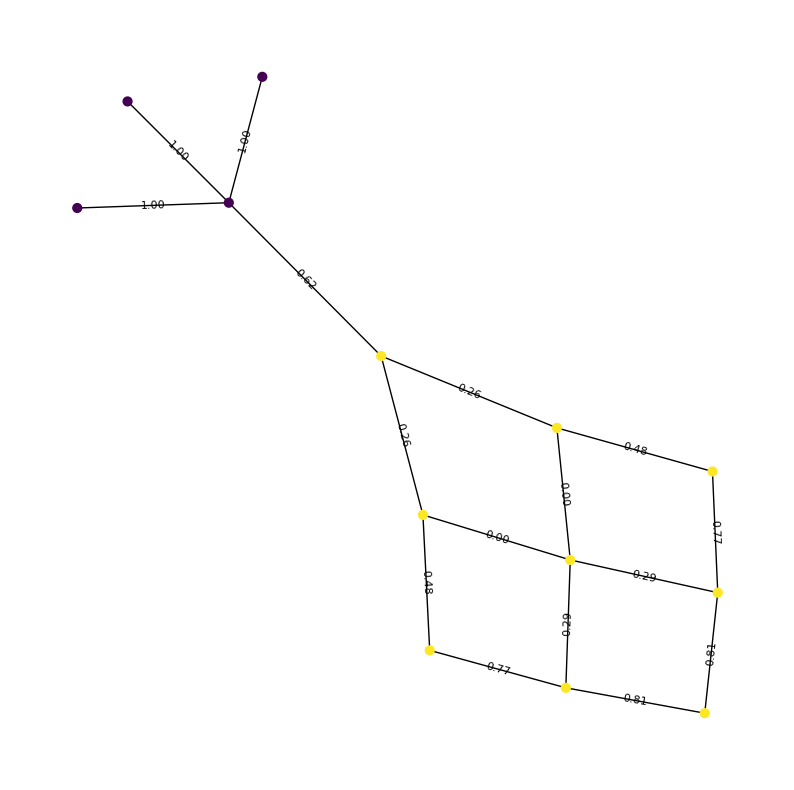

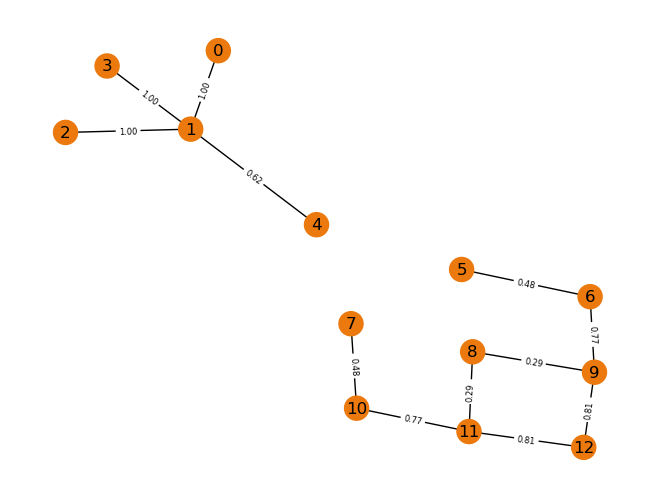

In [14]:
k = 12

mlp.eval()
modelNodeGNN.eval()

#AUCNode = [i for i in range(511,871,6)]
#AUCNode = [i for i in range(a[0].item(),a[len(a)-1]+1,6)]


evaluation.evaluateNodeExplainerAUC(mlp, modelNodeGNN, data, data.edge_index, currentAUC)

subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=currentAUC, num_hops=3, edge_index=data.edge_index, relabel_nodes=True)

indexNodeToPred = (subset == currentAUC).nonzero().item()

G_hop = Data(x=data.x[subset], edge_index=edge_index_hop, y=data.y[subset])

pos = utils.plotTreeCycles(G_hop)




w_ij = mlp.forward(modelNodeGNN, data.x[subset], edge_index_hop, indexNodeToPred)

# Min-Max Normalization. This works pretty well
weights_min = w_ij.min()
weights_max = w_ij.max()
weights_norm = (w_ij - weights_min) / (weights_max - weights_min)

edge_ij = mlp.sampleGraph(w_ij, temperature)

## REMOVE IF SIGMOID WANTED
edge_ij = weights_norm


#GraphSampled = Data(x=G_hop.x,edge_index=G_hop.edge_index,edge_attr=edge_ij.detach())

pos = utils.plotTreeCycles(G_hop, pos, edge_weights=edge_ij.detach())


# Print topK edges
_, top_k_indices = torch.topk(edge_ij, k=k*2, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = G_hop.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

GtopK = Data(x=G_hop.x, edge_index=edge_index_masked, edge_attr=weights_masked)

pos1 = utils.plotGraph(GtopK, pos=pos, color_map=None, edge_weights=True)

In [214]:
data = datasetLoader.loadOriginalGraphDataset("MUTAG")

In [223]:
train, val, test = datasetLoader.loadGraphDataset("MUTAG")

In [227]:
torch.set_printoptions(threshold=20000)

print(len(train)+len(val)+len(test))
#adj = torch.tensor(data[0])

#edge_index = adj.nonzero().t().contiguous()
#edge_index_undirected = to_undirected(edge_index)
#print(edge_index)

#print(data)

print(data[0].shape)

# features for each node
print(data[1][0].shape)

# Label for each train node
print(data[2].shape)


y_full = torch.zeros_like(torch.tensor(data[2]))
#y_train, y_val, y_test, train_mask, val_mask, test_mask = torch.tensor(data[2]), torch.tensor(data[3]), torch.tensor(data[4]), torch.tensor(data[5]), torch.tensor(data[6]), torch.tensor(data[7])

#y_full[train_mask] = y_train[train_mask]
#y_full[val_mask] = y_val[val_mask]
#y_full[test_mask] = y_test[test_mask]

#print(y_full)

#data = Data(x=data[1],edge_index=edge_index, train_mask=data[5],val_mask=data[6],test_mask=data[7])

4337
(4337, 418, 418)
(418, 14)
(4337, 2)
